In [1]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

In [2]:
# To supress the scientific notation for easier reading.
np.set_printoptions(suppress=True)

# Test Development

In developing the code, three main tests have been completed within one region: Amhara. The first at a very micro level with a custom dummy dataset with only two primary schools and 2 proposed secondary schools. The second is for one woreda/district with 21 primary schools and two secondary schools, whereby 5 secondary schools are proposed. The final test was a region wide test with 1765 primary schools and 1658 secondary schools, with 5 new secondary schools proposed.

In [3]:
# Specify which test to perform
declare_test = 1 # micro test

In [4]:
# Declare key variables according to the test being performed.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908'

if declare_test == 1: # for micro test
    # read in the prepared dataset. Evaluate point data to make it readible by geopandas
    df = pd.read_csv('data/test_dataset2.csv', converters={'point': pd.eval})
    proposed_schools= 2
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
elif declare_test == 2:
    df = pd.read_csv('data/test_dataset.csv', converters={'point': pd.eval})
    proposed_schools= 5
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
else:
    proposed_schools= 5
    df = pd.read_csv('data/clean_dataset.csv', converters={'point': pd.eval})
    # limit geojson to only selected region
    # limit clean dataset to only selected region
    gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
    gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
    df = df.loc[df['region'] == region]
    bounds = gdf_region_shp.bounds 

## Data Preparation

In [5]:
# Establish boundaries based on the bounds of region or woreda.
# Latitude is the Y axis, longitude is the X axis.

lat_bounds = bounds[['miny','maxy']].to_numpy(dtype=float)[0]
lon_bounds = bounds[['minx','maxx']].to_numpy(dtype=float)[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
# array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

[array([10.71371939, 36.68932805, 10.71371939, 36.68932805]),
 array([10.96477258, 36.96973029, 10.96477258, 36.96973029])]

In [6]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Potentially required for calibration function.

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy(dtype=float)
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc], dtype=float)

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)
df_sec_loc = np.array([np.array(i) for i in df_sec_loc], dtype=float)

## Key functions

In [7]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [8]:
def shape(distance, enrollment):
    min_walk = 2 # distance not a factor issuing enrollment until 2km
    max_walk = 5 # distance greater than 5km assumes zero enrollment
    answer = np.rint(np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0.1,
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            ))
    return answer

In [9]:
def expected_enroll(prim_loc, x, prim_enroll, sec_loc):
    x = np.append(sec_loc, x) # The genotype
    x = np.array(np.array_split(x, (len(sec_loc)+proposed_schools)))
    distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
    min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
    return np.sum(min_d*prim_enroll)

In [10]:
def expected_enroll2(prim_loc, x, prim_enroll, sec_loc):
    x = np.append(sec_loc, x) # The genotype
    x = np.array(np.array_split(x, (len(sec_loc)+proposed_schools)))
    distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
    min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
    shaped_enroll = shape(min_d, prim_enroll)
    return np.sum(shaped_enroll)

In [11]:
# The Objective Function
def f(x):
    test_case = expected_enroll(df_prim_loc, x, df_prim_enroll, df_sec_loc)
    return np.round(test_case,3)

In [12]:
# The Objective Function with the shape function included.
def f2(x):
    test_case = expected_enroll2(df_prim_loc, x, df_prim_enroll, df_sec_loc)
    return np.round(test_case,3)*-1

In [13]:
# Create starting points within regional box boundaries.

def create_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=proposed_schools)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=proposed_schools)
    sp = np.vstack((sp1, sp2)).T
    return sp

# create a random starting point within the target region.
def get_random_sp():
    sp = create_random_sp()
    for i in range(0,10000):
        if declare_test == 3:
            if check_region(sp) == True:
                return sp.flatten()
                break
            else:
                sp = create_random_sp()
        else:
            if check_woreda(sp) == True:
                return sp.flatten()
                break
            else:
                sp = create_random_sp()

## Random Search

In [14]:
def random_search(f, n):
    x = [get_random_sp() for _ in range(n)] 
    fx = [(f(xi), xi) for xi in x]
    best_f, best_solution = min(fx, key=lambda x:x[0])
    return best_f, best_solution

In [15]:
fx = [random_search(f, 10000) for _ in range(4)]

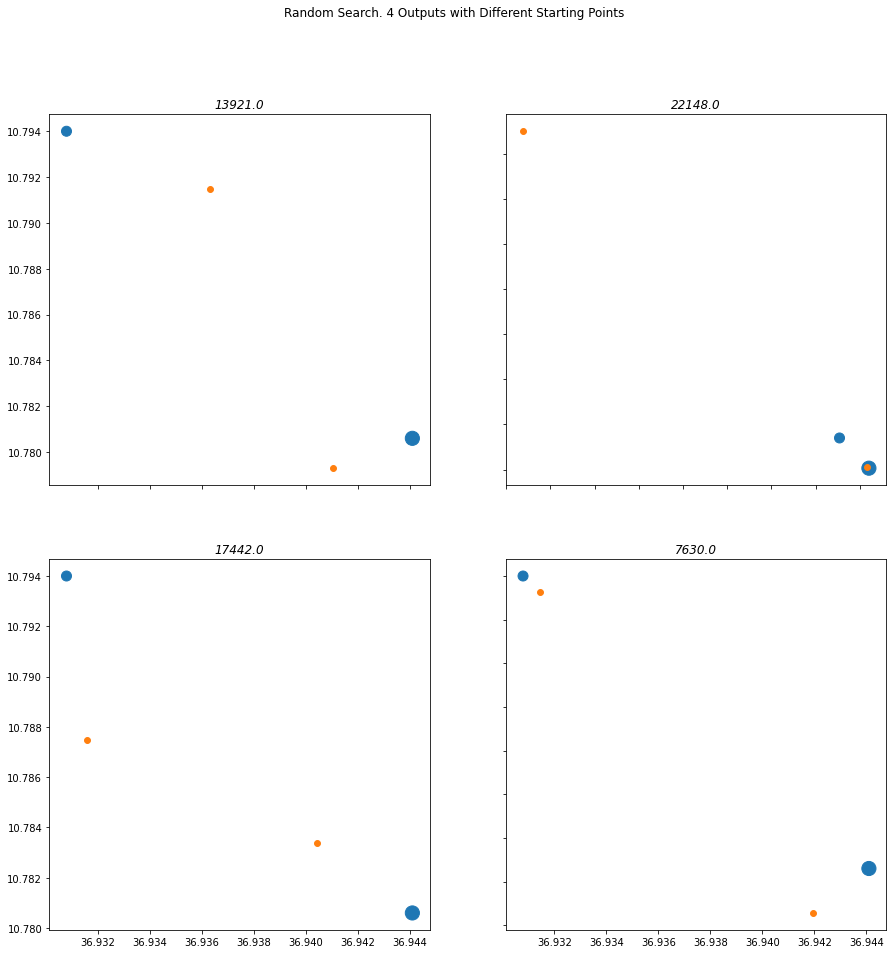

In [16]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Random Search F(1). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fx[i][1][1::2], fx[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title(np.round(fx[i][0],0), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [17]:
fx2 = [random_search(f2, 10000) for _ in range(4)]

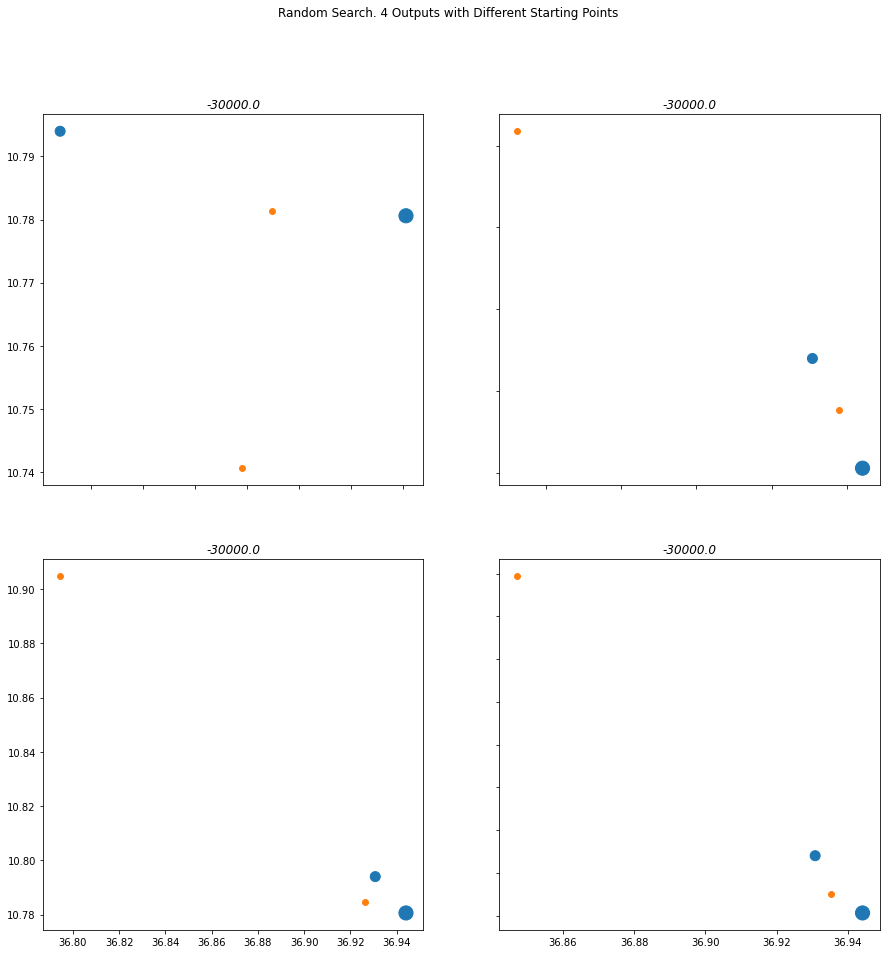

In [18]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Random Search F(2). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fx2[i][1][1::2], fx2[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title(np.round(fx2[i][0],0), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

## CMA

In [21]:
sigmas = (0.01, 0.05, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24)
maxits = 10000

In [22]:
fcma = []

for i in range(4):
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f, iterations=maxits / es.popsize)
        fcma.append((es.result[1], es.result[0], j))
        
fcma_s = sorted(fcma, key=lambda t: t[0])[:4]

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:13:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 6.896864400000000e+04 1.0e+00 1.06e-02  1e-02  1e-02 0:00.0
    2     16 5.275108900000000e+04 1.6e+00 1.21e-02  1e-02  1e-02 0:00.0
    3     24 3.910406500000000e+04 1.8e+00 1.26e-02  1e-02  1e-02 0:00.0
  100    800 2.081023100000000e+04 6.2e+03 8.38e-06  4e-09  3e-05 0:00.2
NOTE (module=cma, iteration=110):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.2e+08 to 4.2e+00
  139   1112 2.081022700000000e+04 9.3e+00 2.33e-06  1e-10  9e-06 0:00.3
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:13:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.381037570000000e+05 1.0e+00 4.42e-02  4e-02  4e-02 0:00.0
    2     16 1.337152160000000e+05 1.3e+00 5.33e-02  5e-02  6e-02 0:00.0
    3     24 1.28389

NOTE (module=cma, iteration=108):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.9e+08 to 6.9e+01
  150   1200 2.081022700000000e+04 4.8e+01 7.43e-06  2e-10  2e-05 0:00.4
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:13:24 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.132935850000000e+05 1.0e+00 1.07e-01  1e-01  1e-01 0:00.0
    2     16 4.458202700000000e+04 1.2e+00 9.88e-02  8e-02  1e-01 0:00.0
    3     24 6.751774200000000e+04 1.3e+00 9.46e-02  8e-02  9e-02 0:00.0
  100    800 2.081023900000000e+04 2.6e+03 2.17e-05  1e-08  3e-05 0:00.3
NOTE (module=cma, iteration=114):  
condition in coordinate system exceeded 1.6e+08, rescaled to 1.0e+00, 
condition changed from 1.2e+08 to 2.4e+01
  135   1080 2.081022700000000e+04 7.5e+00 2.85e-06  2e-10  6e-06 0:00.4
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:13:25 2022)
Iterat #Fevals  

    2     16 8.298068799999999e+04 1.3e+00 1.60e-01  1e-01  2e-01 0:00.0
    3     24 2.399356100000000e+04 1.5e+00 1.58e-01  1e-01  2e-01 0:00.0
  100    800 2.081039100000000e+04 2.3e+03 1.62e-04  2e-07  3e-04 0:00.3
NOTE (module=cma, iteration=121):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.4e+08 to 2.5e+01
  150   1200 2.081022700000000e+04 2.5e+01 3.87e-06  1e-10  1e-05 0:00.3
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:13:42 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.331063170000000e+05 1.0e+00 1.58e-01  2e-01  2e-01 0:00.0
    2     16 9.684338099999999e+04 1.2e+00 1.50e-01  1e-01  1e-01 0:00.0
    3     24 8.747119800000000e+04 1.4e+00 1.19e-01  9e-02  1e-01 0:00.0
  100    800 2.081023700000000e+04 5.7e+03 4.40e-05  2e-08  1e-04 0:00.1
NOTE (module=cma, iteration=106):  
condition in coordinate system exceeded 1.6e+08, rescaled to 1.0e+00, 


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:13:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 7.112379100000000e+04 1.0e+00 1.91e-01  2e-01  2e-01 0:00.0
    2     16 1.572153890000000e+05 1.3e+00 1.84e-01  2e-01  2e-01 0:00.0
    3     24 1.191887440000000e+05 1.6e+00 1.61e-01  1e-01  2e-01 0:00.0
  100    800 2.081026300000000e+04 2.2e+03 5.67e-05  3e-08  7e-05 0:00.1
NOTE (module=cma, iteration=114):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.0e+08 to 1.5e+01
  145   1160 2.081022700000000e+04 9.0e+00 5.11e-06  2e-10  9e-06 0:00.2
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:14:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.393625560000000e+05 1.0e+00 1.84e-01  2e-01  2e-01 0:00.0
    2     16 1.461504470000000e+05 1.2e+00 1.58e-01  1e-01  2e-01 0:00.0
    3     24 1.05820

In [23]:
fcma_s

[(0.0, array([10.794 , 36.9308, 10.7806, 36.9441]), 0.05),
 (0.0, array([10.7806, 36.9441, 10.794 , 36.9308]), 0.18),
 (0.0, array([10.794 , 36.9308, 10.7806, 36.9441]), 0.2),
 (0.0, array([10.794 , 36.9308, 10.7806, 36.9441]), 0.16)]

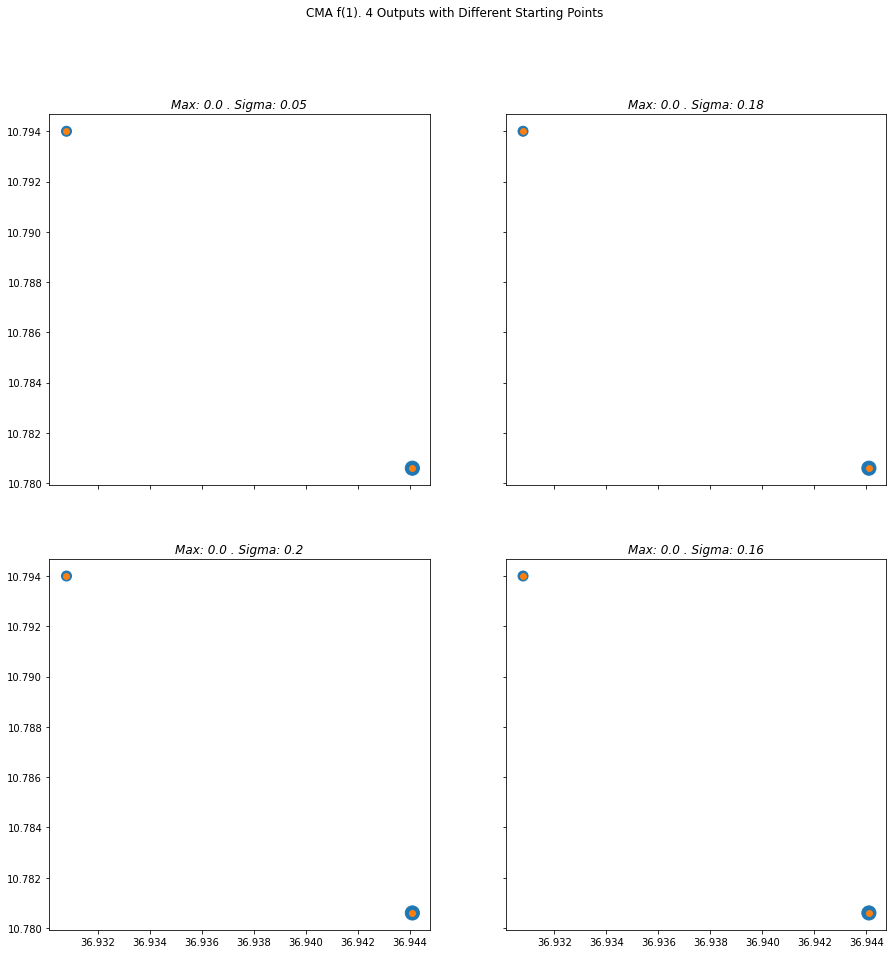

In [24]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('CMA f(1). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fcma_s[i][1][1::2], fcma_s[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title('Max: ' + str(np.round(fcma_s[i][0],0))+ ' . Sigma: ' + str(fcma_s[i][2]), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [25]:
fcma2 = []

for i in range(4):
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f2, iterations=maxits / es.popsize)
        fcma2.append((es.result[1], es.result[0], j))
        
fcma2_s = sorted(fcma2, key=lambda t: t[0])[:4]

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:14:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.235200000000000e+04 1.0e+00 1.11e-02  1e-02  1e-02 0:00.0
    2     16 -2.633400000000000e+04 1.3e+00 1.44e-02  1e-02  2e-02 0:00.0
    3     24 -3.000000000000000e+04 1.4e+00 2.01e-02  2e-02  2e-02 0:00.0
   15    120 -3.000000000000000e+04 2.9e+00 1.45e-02  7e-03  2e-02 0:00.1
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:14:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -3.000000000000000e+04 1.0e+00 4.40e-02  4e-02  4e-02 0:00.0
    2     16 -2.570400000000000e+04 1.3e+00 4.45e-02  4e-02  5e-02 0:00.0
    3     24 -2.691900000000000e+04 1.5e+00 4.56e-02  3e-02  5e-02 0:00.0
   23    184 -3.000000000000000e+04 3.1e+00 3.08e-02  1e-02  2e-02 0:00.1
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Thu Jun 30 19:14:03 2022)


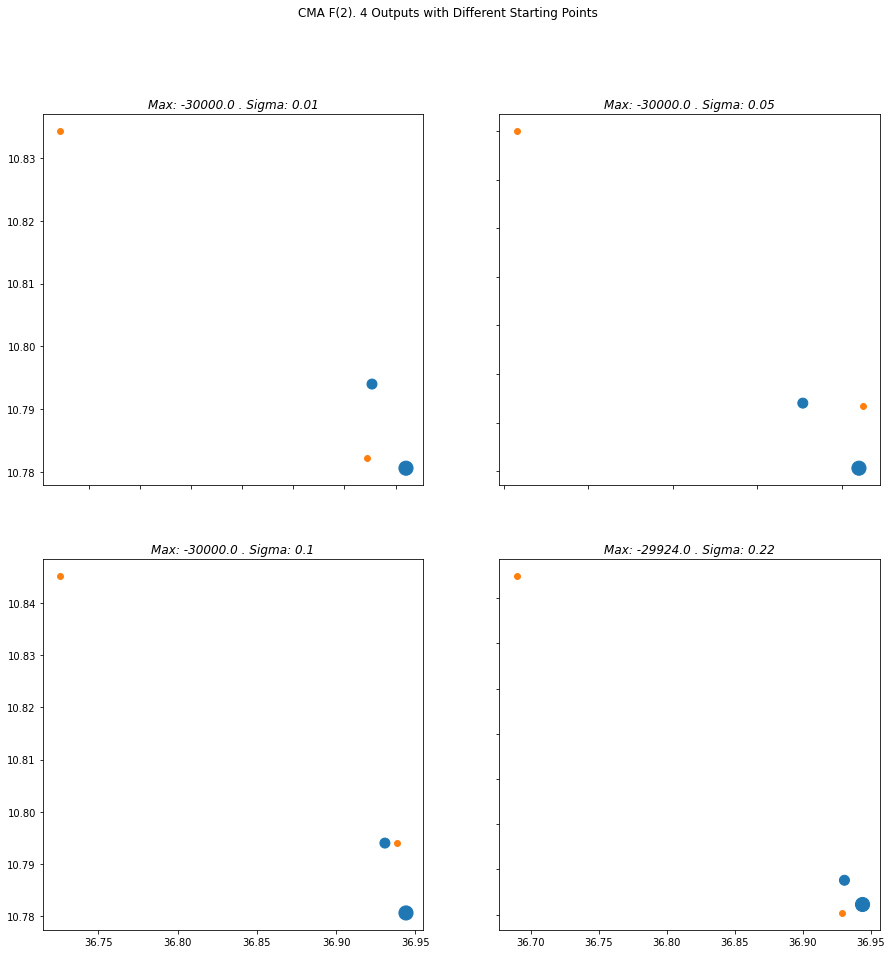

In [26]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('CMA F(2). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fcma2_s[i][1][1::2], fcma2_s[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title('Max: ' + str(np.round(fcma2_s[i][0],0))+ ' . Sigma: ' + str(fcma2_s[i][2]), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()